In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import seaborn as sns

In [150]:
EXPORT = 40
CO2L = 0.80
CLUSTERS = 4
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.15

RUN = "gadm1_3H_ws"
CATEGORY = "postnetworks"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_Co2L{CO2L}0_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/aldehyde/"
OUTPUT = PREFIX + "results"
INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"
OUTPUT_SCENARIO = f"{OUTPUT}/{RUN}/graphics/demand/{SCENARIO}"
OUTPUT_RAW = f"{OUTPUT}/{RUN}/graphics/demand/"

In [151]:
n = pypsa.Network(INPUT)

INFO:pypsa.io:Imported network elec_s_4_ec_lc3.0_Co2L0.80_3H_2030_0.15_DF_40export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Get total demands/loads

Possible demands:
- Should all be in n.loads and n.links

In [152]:
# Get all loads grouped by carrier
loads_raw = n.loads_t.p.groupby(n.loads.carrier, axis=1).sum()
# Get all loads with "emissions" in the name. Note: This does not include emissions from generators as coal etc.
emissions = loads_raw.loc[:, loads_raw.columns.str.contains("emissions")]
# Get all loads without "emissions" in the name
loads = loads_raw.loc[:, ~loads_raw.columns.str.contains("emissions")]

#loads.head()

In [153]:
# Get the annual sum of all loads per carrier in TWh
load_pc = loads.sum(axis=0) * n.snapshot_weightings.generators[0] / 1e6 # TWh

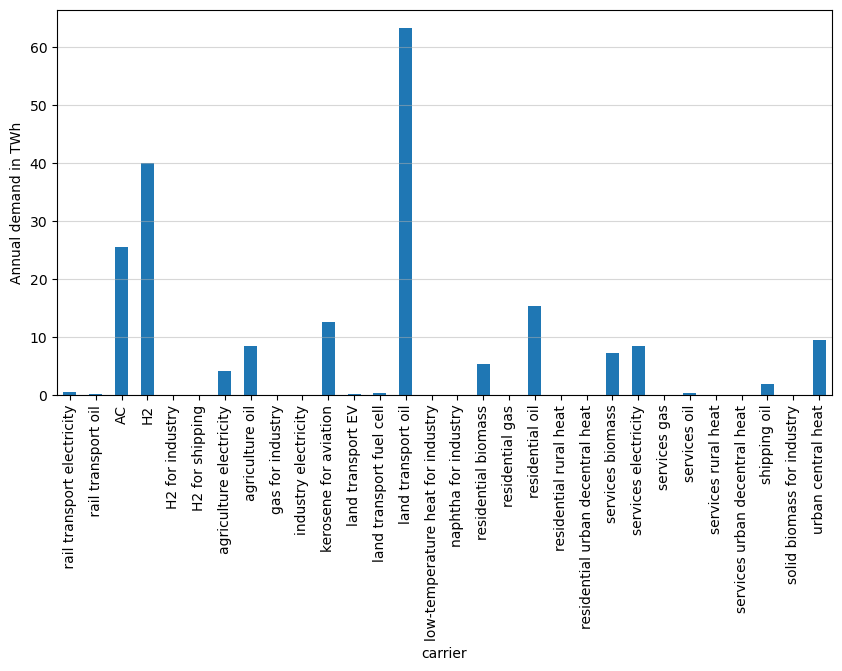

In [154]:
# Stacked barplot of the annual sum of all loads per carrier
fig, ax = plt.subplots(figsize=(10, 5))
load_pc.plot.bar(ax=ax, stacked=True)
ax.set_ylabel("Annual demand in TWh")
ax.grid(axis="y", alpha = 0.5)

### Get hourly demands/loads

In [155]:
# Get total sum of all loads per hour
load_ph = loads.sum(axis=1)

### Hourly demand above threshold

In [156]:
# Get all loads with a total annual sum of above threshold
threshold = 2 * 1e6 # TWh
loads_high = loads.loc[:, loads.sum(axis=0)*n.snapshot_weightings.generators[0] >= threshold]

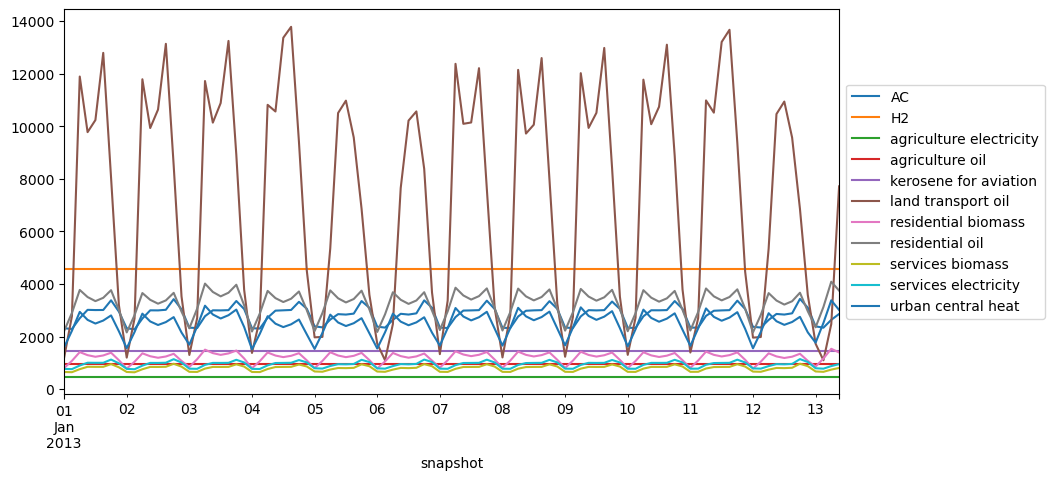

In [157]:
fig, ax = plt.subplots(figsize=(10, 5))
loads_high.iloc[:100].plot(ax=ax)
# Legend position to the right outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Loads connected to the electricity bus

In [158]:
# Get all loads which are connected to the bus with carrier "AC"
ac_buses = n.buses[n.buses.carrier == "AC"]
ac_loads = n.loads.loc[n.loads.bus.isin(ac_buses.index)].carrier.unique()
ac_loads

array(['AC', 'industry electricity', ' rail transport electricity',
       'agriculture electricity', 'services electricity'], dtype=object)

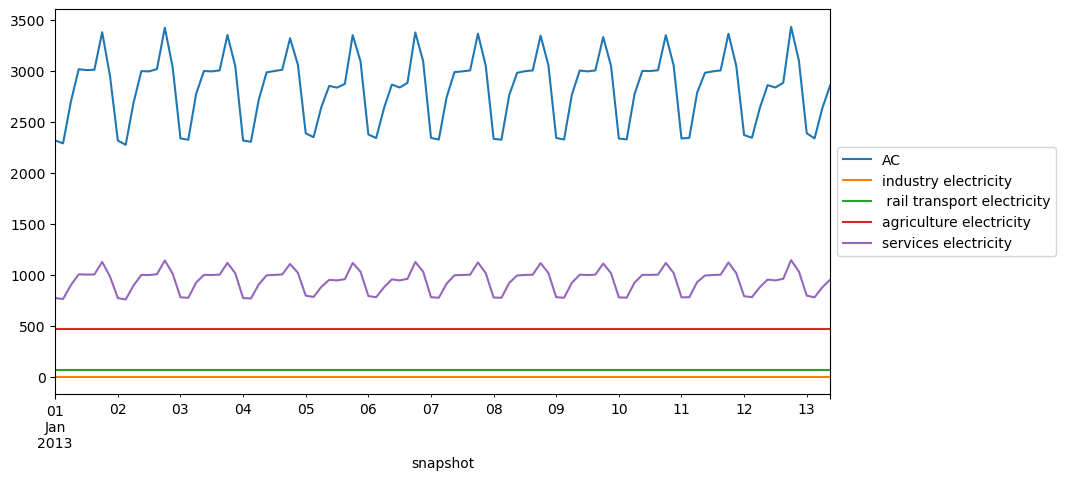

In [159]:
# Select loads with carrier "AC" and plot them
loads_ac = loads.loc[:, ac_loads]
fig, ax = plt.subplots(figsize=(10, 5))
loads_ac.iloc[:100].plot(ax=ax)
# Legend position to the right outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Links connected to the electricity bus

In [160]:
n.links.loc[n.links.bus0.isin(ac_buses.index)].carrier.unique()
ac_links = n.links.loc[n.links.bus0.isin(ac_buses.index)].carrier.unique()
ac_links

In [162]:
# Select loads with carrier "AC" and plot them
links = n.links_t.p0.groupby(n.links.carrier, axis=1).sum()

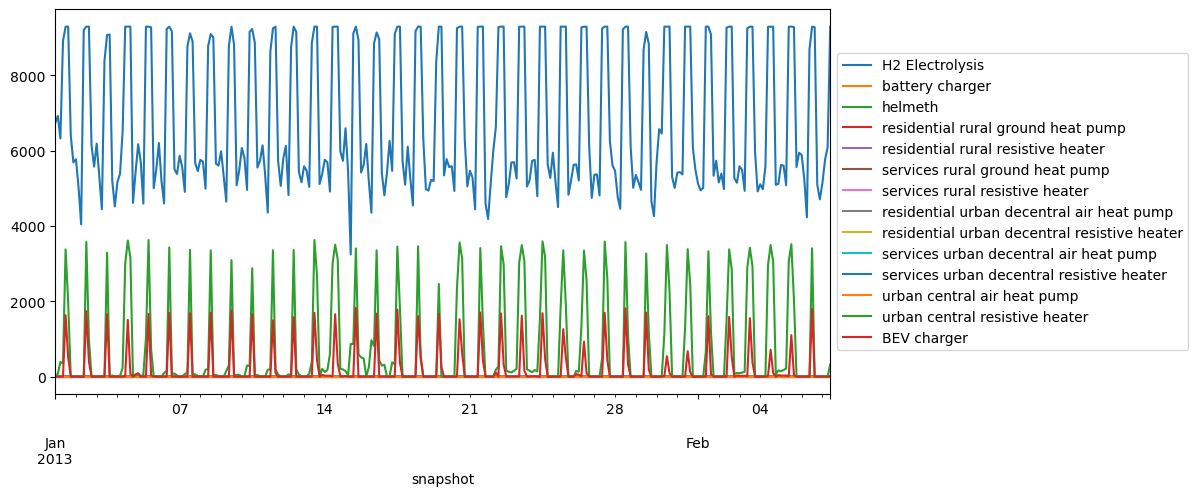

In [164]:
links_ac = links.loc[:, ac_links]
fig, ax = plt.subplots(figsize=(10, 5))
links_ac.iloc[:300].plot(ax=ax)
# Legend position to the right outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()